# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [13]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import shap

from CogniPredictAD.visualization import Visualizer
from lightgbm import LGBMClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 116)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_info_columns', 40) 

warnings.filterwarnings("ignore", category=UserWarning)

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train

,DX,AGE,PTGENDER,PTEDUCAT,MARRIED,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,2,77,0,16,1,1,28,2.5,5,1,0,24,108,47,5,63.63640,-4.84005,2.250,2.111110,1.000000,1.00,1.333330,1.00,2.375000,2.111110,2.428570,2.60,2.833330,2.75000,1.222830,0.546883,0.040838,0.004524,0.001882,0.012107,0.011311,0.016977,0.706210
1,0,59,1,16,1,1,30,0.0,0,19,0,30,47,71,2,0.00000,5.42702,1.000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.00000,1.161970,0.215580,0.020445,0.004452,0.002756,0.012935,0.014299,0.025614,0.752850
2,3,77,1,12,1,2,22,8.0,30,0,25,17,300,19,1,100.00000,-18.90540,2.300,1.844446,1.248572,1.58,1.366668,1.75,3.841666,2.847620,3.033334,2.97,3.166668,3.80000,0.924559,0.539360,0.047131,0.002825,0.001348,0.010049,0.009701,0.053417,0.522572
3,2,82,1,20,0,0,26,1.5,21,4,0,24,63,35,1,85.71430,-7.95749,1.850,1.269446,1.166668,1.20,1.466668,1.60,1.941666,1.294444,1.100002,1.16,1.733332,2.10000,1.119130,0.230751,0.020198,0.003736,0.002083,0.013038,0.013942,0.024176,0.637729
4,0,83,0,17,1,0,27,0.0,5,13,3,25,98,57,7,7.14286,-1.94841,1.250,1.333330,1.000000,1.00,1.333330,1.00,1.375000,1.111110,1.666670,1.00,1.833330,1.25000,1.279034,0.273461,0.026879,0.004611,0.002170,0.011387,0.012975,0.052196,0.635279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,0,72,0,18,0,1,30,0.0,4,11,0,26,52,42,7,18.18180,2.22837,1.500,2.333330,1.285710,1.00,2.500000,1.25,1.250000,1.000000,1.200000,1.00,1.333330,1.50000,1.416100,0.164452,0.013555,0.005079,0.003304,0.014043,0.013729,0.027992,0.710296
1930,3,72,0,12,1,1,26,7.0,29,5,18,19,67,34,-1,100.00000,-9.28099,1.500,1.000000,1.142860,1.00,1.000000,1.00,3.250000,2.333330,2.428570,3.20,3.000000,3.50000,1.268520,0.756153,0.080942,0.004383,0.001691,0.011582,0.011346,0.022499,0.711762
1931,0,70,0,17,1,0,29,0.0,23,10,0,20,300,31,4,42.85710,-2.30539,1.125,1.111110,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.00000,1.456170,0.093004,0.007661,0.005042,0.002406,0.013522,0.013008,0.013065,0.711396
1932,0,84,1,12,0,0,30,0.5,16,13,0,26,65,27,1,80.00000,-1.42719,2.000,2.000000,2.000000,2.00,1.500000,2.00,1.625000,1.222220,1.285710,1.25,1.000000,1.66667,1.318880,0.231190,0.021033,0.004567,0.002176,0.012360,0.013614,0.026801,0.663416


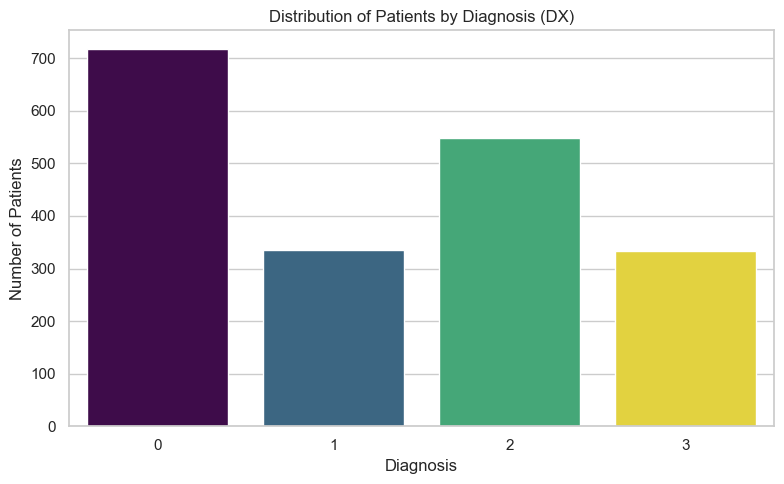

In [14]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = [0, 1, 2, 3],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

In [ ]:
def fit_evaluate_store_models(X_train, y_train, output_dir='../results/all_models'):
    os.makedirs(output_dir, exist_ok=True)

    # Define classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=10, max_features=0.5, min_samples_leaf=10, n_estimators=20),
        'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced', max_depth=10, max_features=0.5, min_samples_leaf=5, n_estimators=40),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=4, min_samples_leaf=5, min_samples_split=2),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', colsample_bytree=0.8, learning_rate=0.1, max_depth=None, n_estimators=50, reg_alpha=1, reg_lambda=0, subsample=0.8),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, colsample_bytree=0.8, learning_rate=0.1, max_depth=None, min_child_samples=5, n_estimators=40, reg_alpha=1, reg_lambda=1, subsample=0.8),
        'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.5),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(C=10.0, class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        'Bagging': BaggingClassifier(random_state=42, n_estimators=30, max_features=1.0, max_samples=1.0)
    }

    # Repeated stratified CV
    cv_splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    metrics_list = []
    per_class_metrics_list = []
    confusion_dict = {}
    confusion_norm_dict = {}
    roc_dict = {}
    saved_model_paths = {}

    # Container to store per-fold accuracies for each model
    accuracies_per_model = {}

    classes = np.unique(y_train)

    for clf_name, clf_model in classifiers.items():
        print(f"Training & Evaluating: {clf_name}")  # progress indicator

        true_all = []
        pred_all = []
        prob_all_list = []        # Collect per-fold probability arrays (aligned)
        fold_accuracies = []      # Collect per-fold accuracies

        # Cross-validation loop
        for train_idx, val_idx in cv_splitter.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            clf_model.fit(X_train_fold, y_train_fold)
            y_pred = clf_model.predict(X_val_fold)

            # Get probability scores
            y_prob = clf_model.predict_proba(X_val_fold)
            
            # Align probabilities columns to classes
            prob_cols = getattr(clf_model, "classes_", None)

            # Create DataFrame and reindex to global `classes` order
            prob_df = pd.DataFrame(y_prob, columns=prob_cols)

            # Reindex: keep columns in the order of `classes`; missing columns -> filled with 0
            prob_df = prob_df.reindex(columns=classes, fill_value=0)

            # Now append the aligned numpy array
            prob_all_list.append(prob_df.values)

            # Aggregate fold results
            true_all.extend(y_val_fold)
            pred_all.extend(y_pred)

            # Compute fold accuracy
            fold_acc = accuracy_score(y_val_fold, y_pred)
            fold_accuracies.append(fold_acc)

        # Store fold accuracies for violin plot
        accuracies_per_model[clf_name] = fold_accuracies

        # Stack probabilities from all folds
        prob_all = np.vstack(prob_all_list) if len(prob_all_list) > 0 else np.empty((0, len(classes)))

        true_all = np.array(true_all)
        pred_all = np.array(pred_all)

        # Global / weighted metrics
        clf_metrics = {
            'Model': clf_name,
            'Accuracy': accuracy_score(true_all, pred_all),
            'Precision (weighted)': precision_score(true_all, pred_all, average='weighted', zero_division=0),
            'Recall (weighted)': recall_score(true_all, pred_all, average='weighted'),
            'F1 Score (weighted)': f1_score(true_all, pred_all, average='weighted'),
            'ROC AUC (macro)': roc_auc_score(label_binarize(true_all, classes=classes), prob_all, average='macro', multi_class='ovr')
        }
        metrics_list.append(clf_metrics)

        # Per-class metrics
        class_report = classification_report(true_all, pred_all, labels=classes, output_dict=True, zero_division=0)
        for cls in classes:
            rep = class_report.get(str(cls), {})
            per_class_metrics_list.append({
                'Model': clf_name,
                'Class': cls,
                'Precision': rep.get('precision', 0.0),
                'Recall': rep.get('recall', 0.0),
                'F1 Score': rep.get('f1-score', 0.0),
                'Support': rep.get('support', 0)
            })

        # Confusion matrix (counts and normalized)
        cm = confusion_matrix(true_all, pred_all, labels=classes)
        confusion_dict[clf_name] = cm

        row_sums = cm.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
            cm_norm = np.nan_to_num(cm_norm)
        confusion_norm_dict[clf_name] = cm_norm

        # ROC One-vs-Rest per class
        y_true_bin = label_binarize(true_all, classes=classes)
        fpr_dict = {}
        tpr_dict = {}
        auc_dict = {}
        for i, cls in enumerate(classes):
            if y_true_bin[:, i].sum() == 0:
                fpr_dict[cls] = np.array([0.0, 1.0])
                tpr_dict[cls] = np.array([0.0, 1.0])
                auc_dict[cls] = np.nan
                continue
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_all[:, i])
            auc_val = roc_auc_score(y_true_bin[:, i], prob_all[:, i])
            fpr_dict[cls] = fpr
            tpr_dict[cls] = tpr
            auc_dict[cls] = auc_val
        roc_dict[clf_name] = (fpr_dict, tpr_dict, auc_dict)

        # Refit model on the full training set before saving
        clf_model.fit(X_train, y_train)
        joblib.dump(clf_model, os.path.join(output_dir, f"{clf_name.replace(' ', '_')}.joblib"), compress=3)
        saved_model_paths[clf_name] = os.path.join(output_dir, f"{clf_name.replace(' ', '_')}.joblib")

    # Results DataFrame
    results_df = pd.DataFrame(metrics_list).sort_values('ROC AUC (macro)', ascending=False)
    display(results_df)

    # Per-class metrics DataFrame
    per_class_df = pd.DataFrame(per_class_metrics_list)
    display(per_class_df)

    # Plot ROC curves: one figure per class (all models compared on that class)
    for cls in classes:
        plt.figure(figsize=(8, 6))
        for clf_name, (fpr_dict, tpr_dict, auc_dict) in roc_dict.items():
            auc_val = auc_dict[cls]
            plt.plot(fpr_dict[cls], tpr_dict[cls],
                     label=f'{clf_name} (AUC={auc_val:.2f})' if not np.isnan(auc_val) else f'{clf_name} (AUC=nan)')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Class {cls} (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Plot confusion matrices (absolute counts)
    n_classifiers = len(confusion_dict)
    n_cols = 4
    n_rows = n_classifiers // n_cols + int(n_classifiers % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm) in enumerate(confusion_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

    # Plot normalized confusion matrices
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm_norm) in enumerate(confusion_norm_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Normalized Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_norm_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

    # Violin plot of per-fold accuracies for each model
    violin_rows = []
    for model_name, acc_list in accuracies_per_model.items():
        for acc in acc_list:
            violin_rows.append({'Model': model_name, 'Accuracy': acc})
    if violin_rows:
        violin_df = pd.DataFrame(violin_rows)
        plt.figure(figsize=(12, 8))
        sns.violinplot(x='Model', y='Accuracy', data=violin_df, inner='quartile')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Comparison (per-fold distributions)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        

In [16]:
def run_gridsearch(X_train, y_train, cv=5, scoring='f1_weighted'):
    """
    Runs GridSearchCV on multiple classifiers with their respective parameter grids.
    The classifiers and parameter grids are predefined inside the function.

    Parameters
    ----------
    X_train : array-like
        Training feature matrix.
    y_train : array-like
        Training target vector.
    cv : int, default=5
        Number of folds for cross-validation.
    scoring : str, default='f1_macro'
        Scoring metric to optimize (e.g., 'accuracy', 'roc_auc', 'f1_macro').

    Returns
    -------
    best_models : dict
        Dictionary containing best estimator, parameters, and score for each classifier.
    """

    # === Classifiers definitions ===
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ]),
        'Bagging': BaggingClassifier(random_state=42)
    }

    # === Parameter grids ===
    param_grids = {
        'Random Forest': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_depth': [None, 10, 6, 4],
            'min_samples_leaf': [1, 4, 10],
            'max_features': ['sqrt', 0.5]
        },
        'Extra Trees': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_depth': [None, 10, 6],
            'min_samples_leaf': [1, 4, 10],
            'max_features': ['sqrt', 0.5]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 6, 4],
            'min_samples_split': [2, 8, 20],
            'min_samples_leaf': [1, 4, 10]
        },
        'XGBoost': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 6, 10],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.7, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [1, 5]
        },
        'LightGBM': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [0.1, 0.05, 0.01],
            'num_leaves': [31, 15],
            'max_depth': [4, 6, 10],
            'min_child_samples': [5, 20, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.7, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [0, 1]
        },
        'AdaBoost': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [1.0, 0.5, 0.1],
        },
        'Logistic Regression': {
            'logreg__C': [0.01, 0.1, 1.0, 10.0],
            'logreg__penalty': ['l2']
        },
        'Bagging': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_samples': [0.6, 0.8, 1.0],
            'max_features': [0.6, 0.8, 1.0]
        }
    }

    # === Run GridSearch for each classifier ===
    best_models = {}

    for name, clf in classifiers.items():
        print(f"\nRunning GridSearch for {name} ...")
        param_grid = param_grids[name]

        # Define GridSearchCV
        grid = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,    # Use all available CPU cores
            verbose=1
        )

        # Fit on training data
        grid.fit(X_train, y_train)

        # Store results
        best_models[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": grid.best_params_,
            "best_score": grid.best_score_
        }

        # Print best params and score
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best {scoring}: {grid.best_score_:.4f}")

    return best_models

In [27]:
train.groupby('DX')[['CDRSB','LDELTOTAL','mPACCdigit']].describe()

CDRSB                                               LDELTOTAL             \
    count      mean       std  min  25%  50%  75%   max     count       mean   
DX                                                                             
0   717.0  0.039052  0.139365  0.0  0.0  0.0  0.0   1.0     717.0  13.048815   
1   336.0  1.322917  0.854686  0.0  0.5  1.0  1.5   6.0     336.0   9.181548   
2   548.0  1.631387  0.955155  0.0  1.0  1.5  2.0   5.0     548.0   3.937956   
3   333.0  4.412913  1.712792  1.0  3.5  4.5  5.0  10.0     333.0   1.459459   

                                          mPACCdigit                       \
         std  min   25%   50%   75%   max      count       mean       std   
DX                                                                          
0   3.457098  3.0  11.0  13.0  16.0  22.0      717.0  -0.072772  2.752304   
1   2.184016  5.0   8.0   9.0  10.0  20.0      336.0  -3.647002  3.141806   
2   2.602168  0.0   2.0   4.0   6.0  12.0      548.0  -7.662755  3.758303   
3   2.054017  0.0   0.0   0.0   2.0  11.0      333.0 -15.062370  3.545008   

                                                      
         min       25%        50%       75%      max  
DX                                                    
0   -9.33811  -1.84844   0.115011   1.94279  6.30031  
1  -15.78530  -5.77534  -3.115770  -1.56286  5.02719  
2  -21.99700 -10.37100  -7.683795  -4.70081  1.38465  
3  -23.60340 -17.74170 -15.232500 -12.42960 -3.04793

Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: Decision Tree
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: AdaBoost
Training & Evaluating: Logistic Regression


,Model,Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
3,XGBoost,0.930369,0.930477,0.930369,0.930266,0.987772
4,LightGBM,0.930024,0.930061,0.930024,0.929891,0.987276
0,Random Forest,0.913478,0.915792,0.913478,0.914120,0.985065
1,Extra Trees,0.892451,0.896479,0.892451,0.893483,0.981649
6,Logistic Regression,0.887108,0.889568,0.887108,0.887655,0.978883
2,Decision Tree,0.836608,0.864878,0.836608,0.840991,0.961792
5,AdaBoost,0.848673,0.849072,0.848673,0.848317,0.929653


,Model,Class,Precision,Recall,F1 Score,Support
0,Random Forest,0,0.987817,0.942352,0.964549,2151.0
1,Random Forest,1,0.860909,0.939484,0.898482,1008.0
2,Random Forest,2,0.899448,0.892336,0.895878,1644.0
3,Random Forest,3,0.842983,0.859860,0.851338,999.0
4,Extra Trees,0,0.985493,0.947466,0.966106,2151.0
5,Extra Trees,1,0.779029,0.891865,0.831637,1008.0
6,Extra Trees,2,0.873718,0.829075,0.850811,1644.0
7,Extra Trees,3,0.860784,0.878879,0.869737,999.0
8,Decision Tree,0,0.989389,0.910274,0.948184,2151.0
9,Decision Tree,1,0.609524,0.952381,0.743322,1008.0


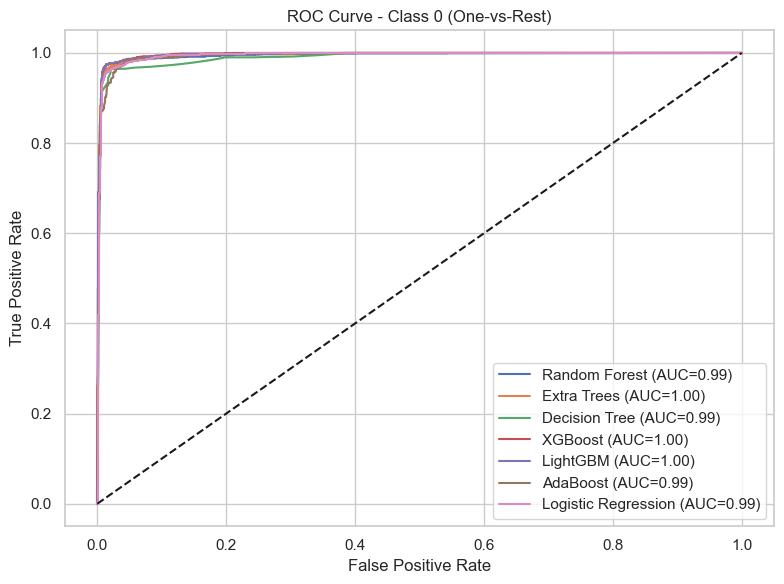

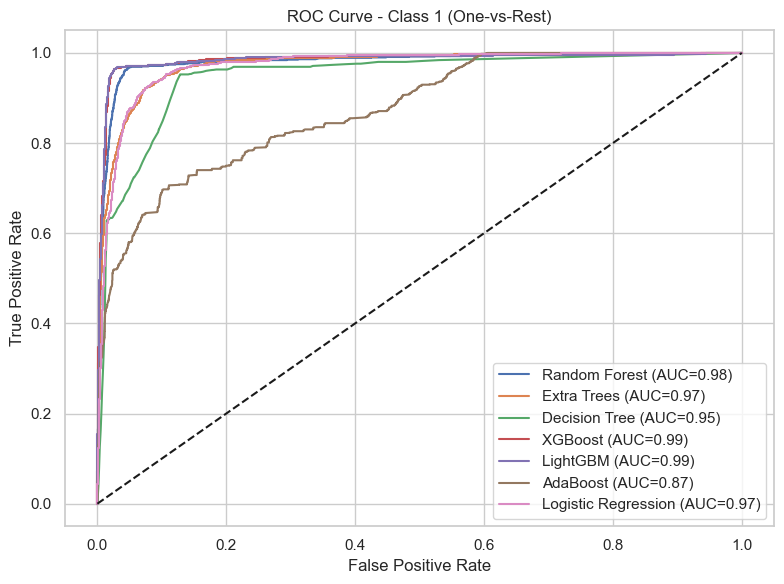

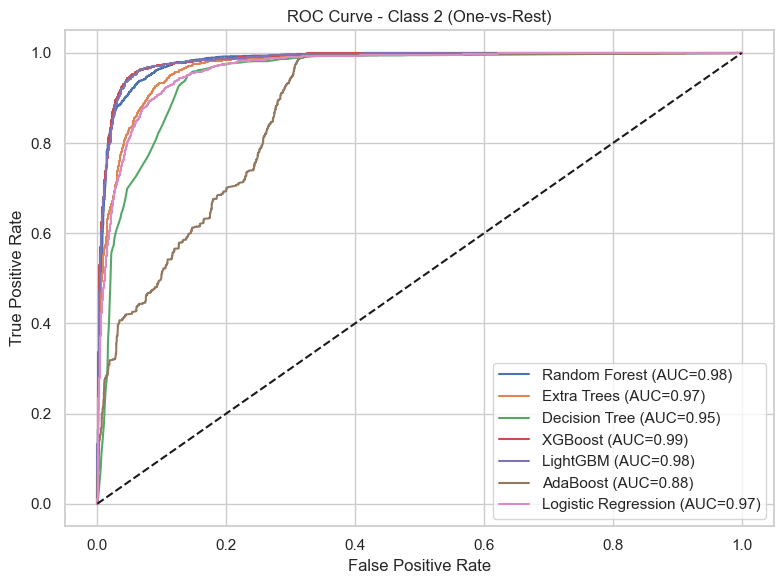

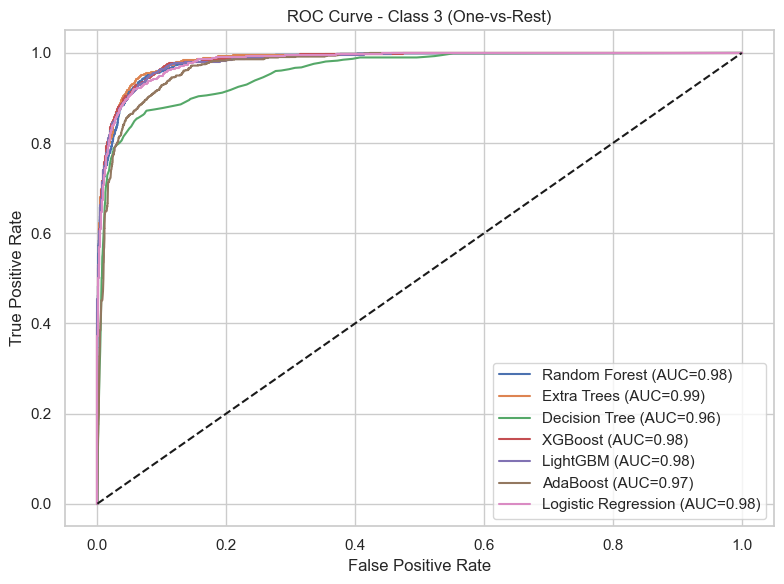

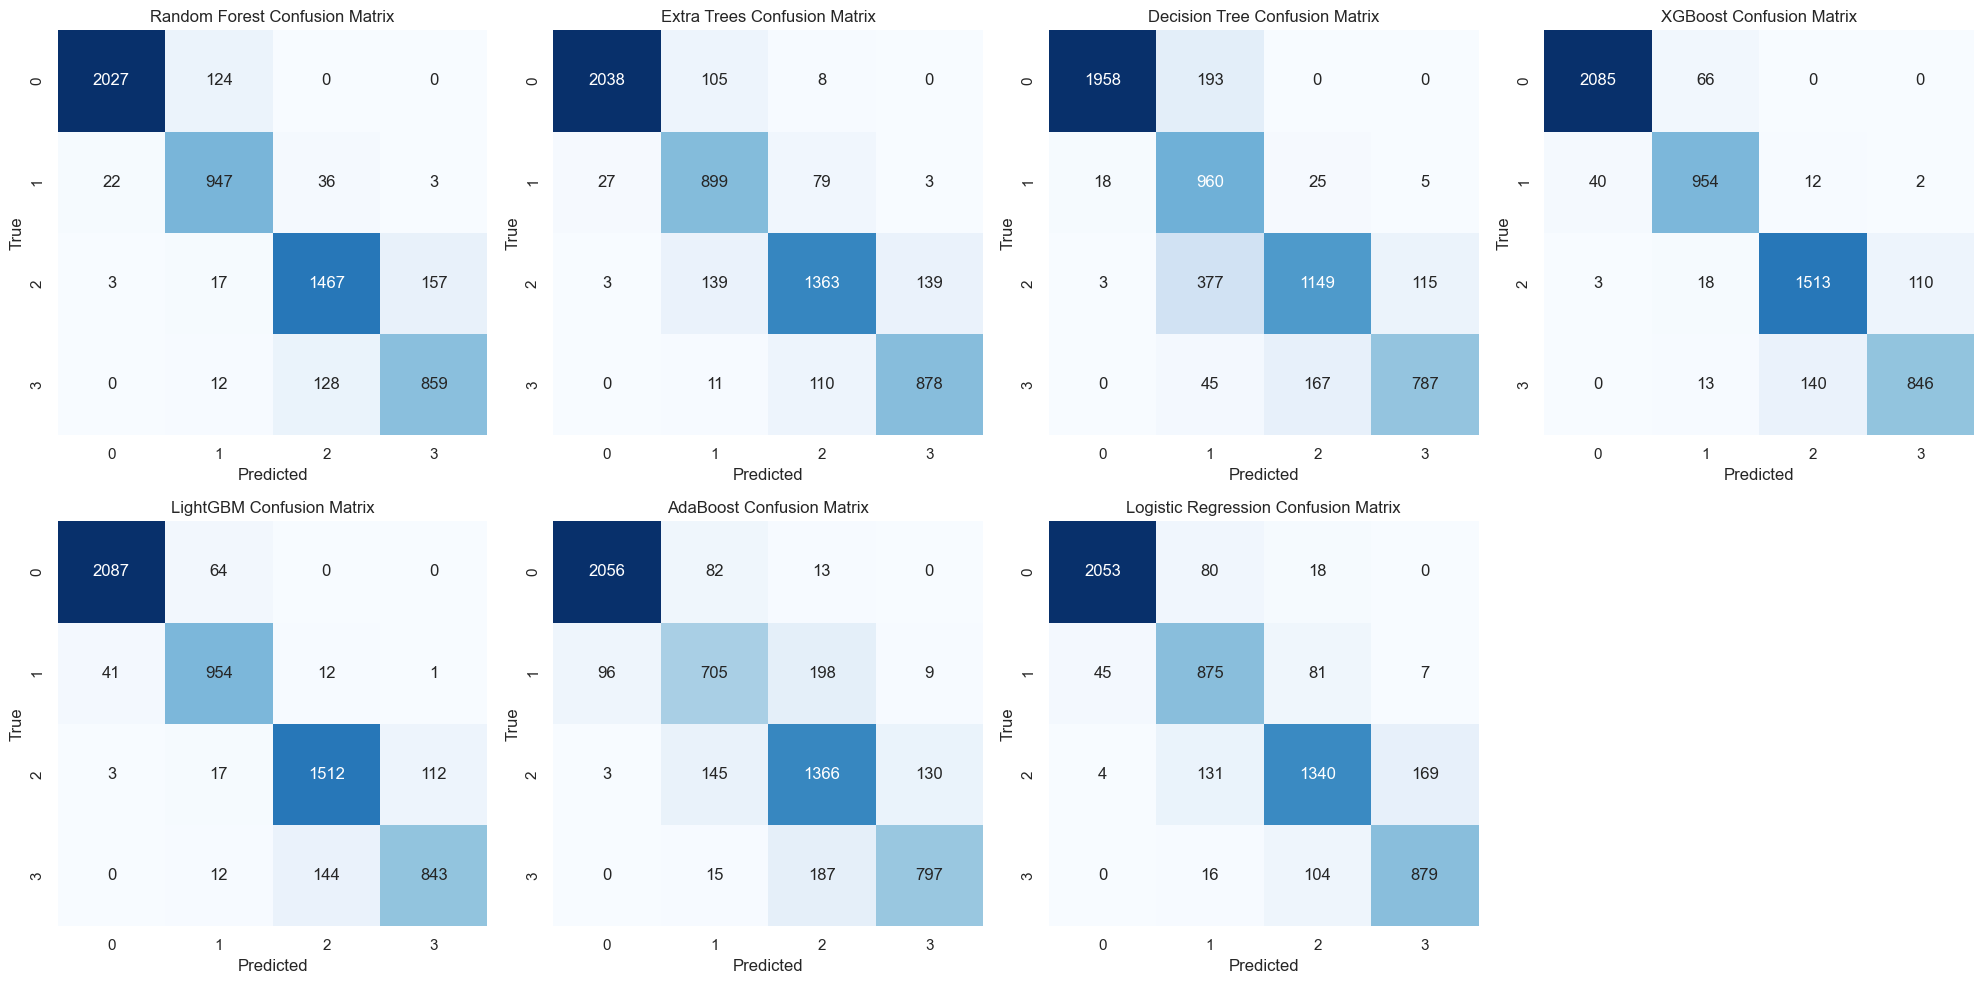

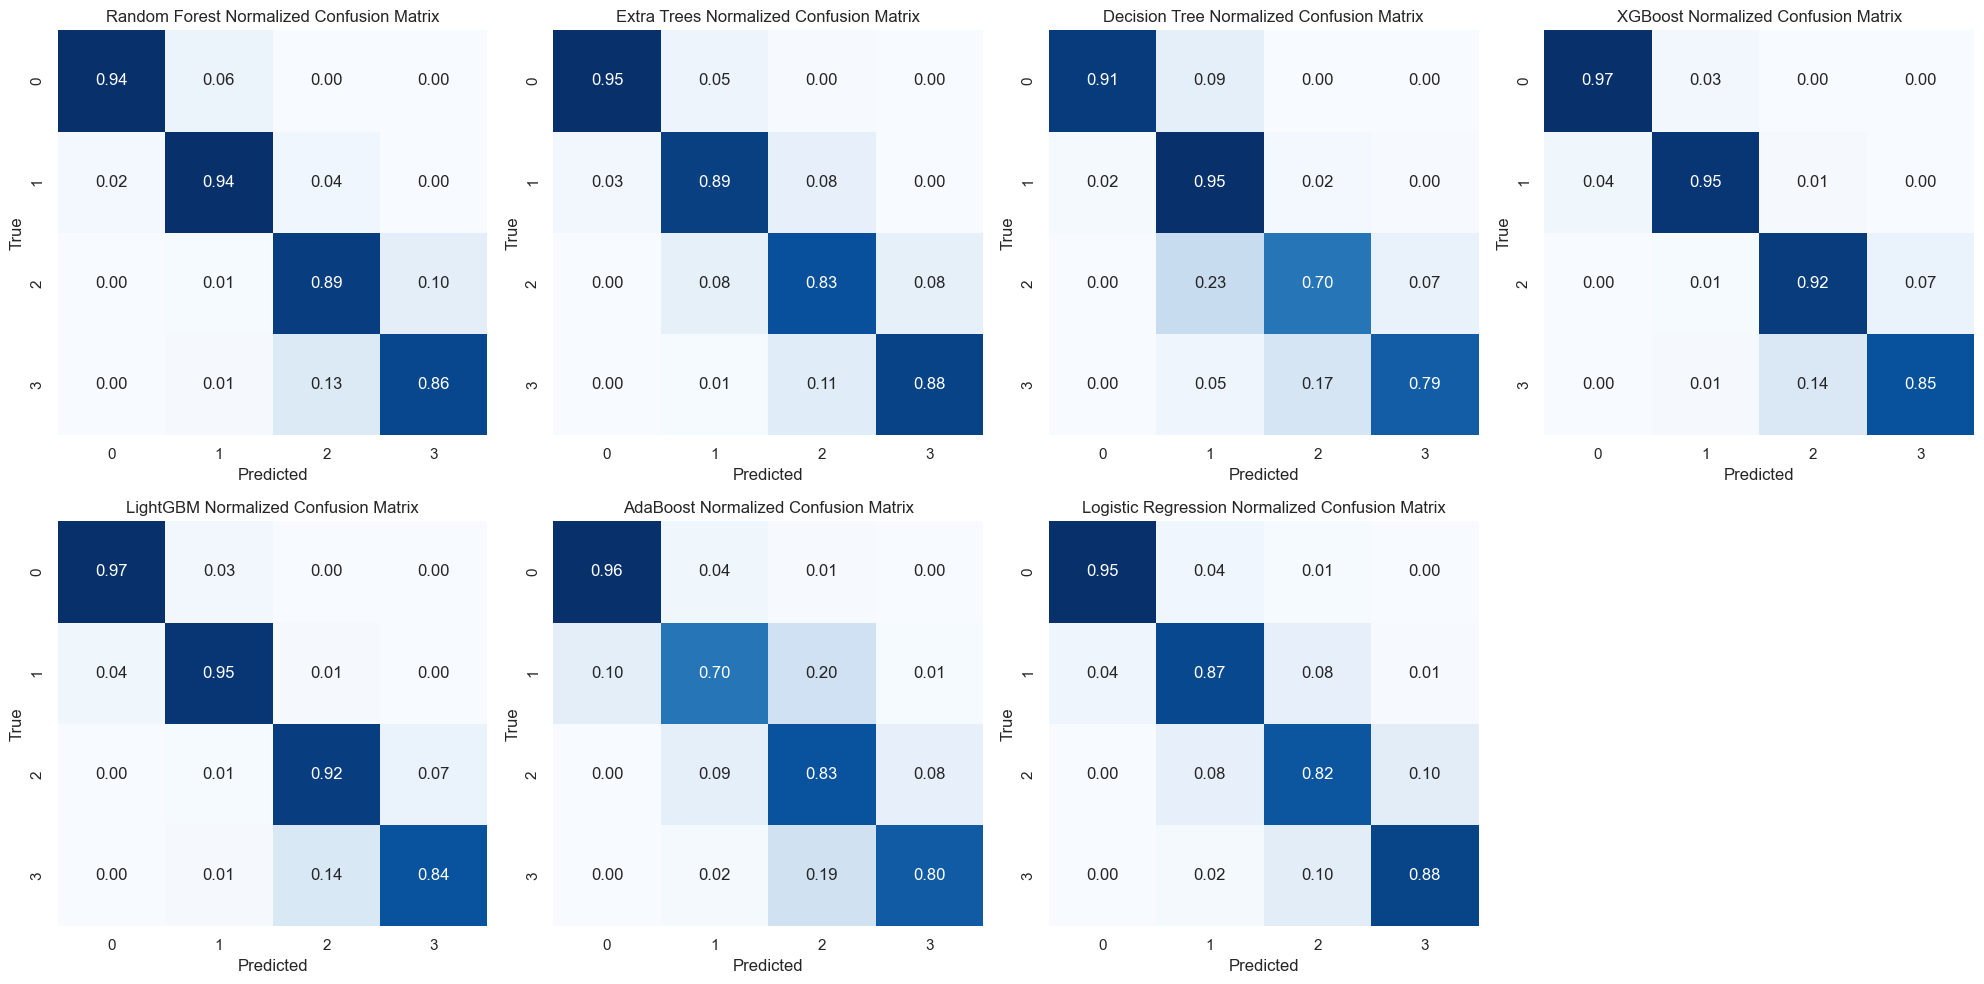

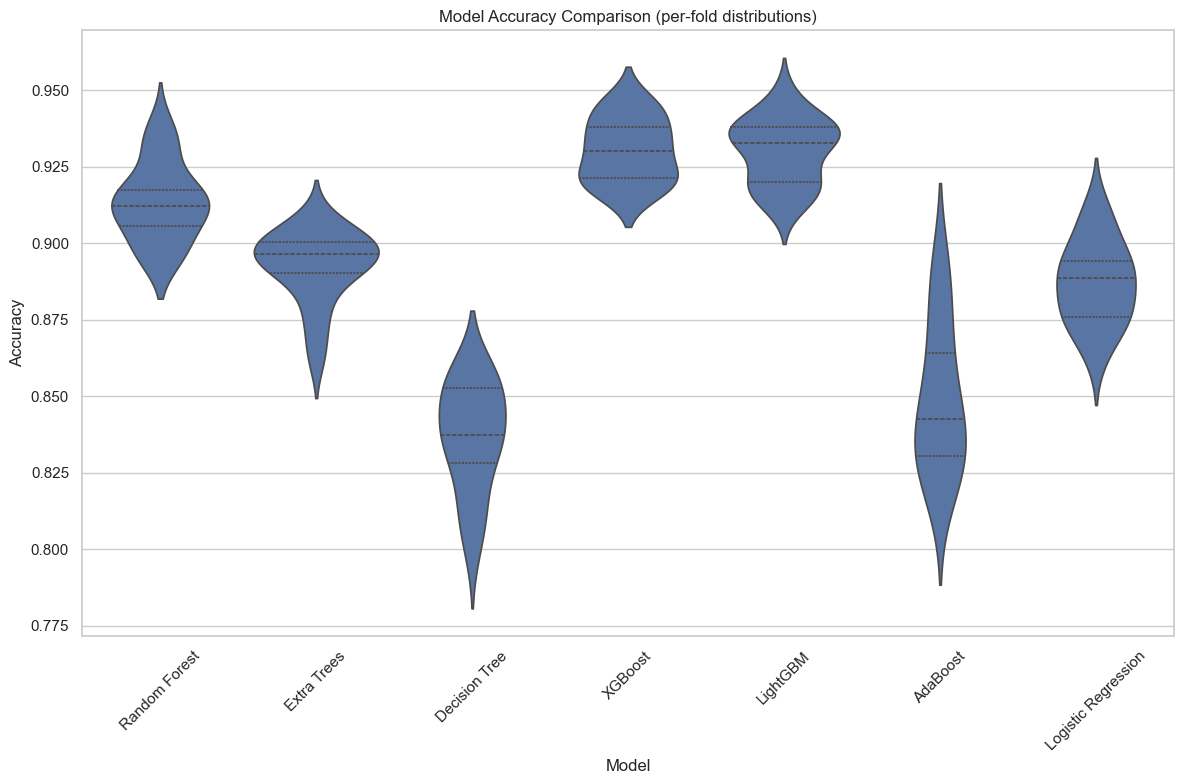

In [18]:
# train = pd.read_csv("../data/gg.csv")
# train.drop(["PTETHNICITY", "Hippocampus", "Entorhinal", "Fusiform", "MidTemp", "Ventricles", "WholeBrain", "ICV", "RAVLT_forgetting", "ABETA", "PTAU", "TAU"], axis=1, inplace=True)
# train.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
# test.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)

# Target column
y_train = train['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])

fit_evaluate_store_models(X_train, y_train)

In [19]:
def fit_evaluate_models_no_cv(X_train, y_train):
    # Define classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=10, max_features=0.5, min_samples_leaf=10, n_estimators=20),
        'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced', max_depth=10, max_features=0.5, min_samples_leaf=5, n_estimators=40),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=4, min_samples_leaf=5, min_samples_split=2),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', colsample_bytree=0.8, learning_rate=0.1, max_depth=None, n_estimators=50, reg_alpha=1, reg_lambda=0, subsample=0.8),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, colsample_bytree=0.8, learning_rate=0.1, max_depth=None, min_child_samples=5, n_estimators=40, reg_alpha=1, reg_lambda=1, subsample=0.8),
        'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.5),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ]),
        'Bagging': BaggingClassifier(random_state=42, n_estimators=30, max_features=1.0, max_samples=1.0)
    }

    metrics_list = []
    per_class_metrics_list = []
    confusion_dict = {}
    confusion_norm_dict = {}
    roc_dict = {}
    
    classes = np.unique(y_train)

    for clf_name, clf_model in classifiers.items():
        print(f"Training & Evaluating: {clf_name}")

        # Fit on the entire training set
        clf_model.fit(X_train, y_train)
        y_pred = clf_model.predict(X_train)
        y_prob = clf_model.predict_proba(X_train)

        # Align probabilities to global classes
        prob_cols = getattr(clf_model, "classes_", None)
        prob_df = pd.DataFrame(y_prob, columns=prob_cols)
        prob_df = prob_df.reindex(columns=classes, fill_value=0)
        prob_all = prob_df.values

        # Global metrics
        clf_metrics = {
            'Model': clf_name,
            'Accuracy': accuracy_score(y_train, y_pred),
            'Precision (weighted)': precision_score(y_train, y_pred, average='weighted', zero_division=0),
            'Recall (weighted)': recall_score(y_train, y_pred, average='weighted'),
            'F1 Score (weighted)': f1_score(y_train, y_pred, average='weighted'),
            'ROC AUC (macro)': roc_auc_score(label_binarize(y_train, classes=classes), prob_all, average='macro', multi_class='ovr')
        }
        metrics_list.append(clf_metrics)

        # Per-class metrics
        class_report = classification_report(y_train, y_pred, labels=classes, output_dict=True, zero_division=0)
        for cls in classes:
            rep = class_report.get(str(cls), {})
            per_class_metrics_list.append({
                'Model': clf_name,
                'Class': cls,
                'Precision': rep.get('precision', 0.0),
                'Recall': rep.get('recall', 0.0),
                'F1 Score': rep.get('f1-score', 0.0),
                'Support': rep.get('support', 0)
            })

        # Confusion matrices
        cm = confusion_matrix(y_train, y_pred, labels=classes)
        confusion_dict[clf_name] = cm
        row_sums = cm.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
            cm_norm = np.nan_to_num(cm_norm)
        confusion_norm_dict[clf_name] = cm_norm

        # ROC curves
        y_true_bin = label_binarize(y_train, classes=classes)
        fpr_dict, tpr_dict, auc_dict = {}, {}, {}
        for i, cls in enumerate(classes):
            if y_true_bin[:, i].sum() == 0:
                fpr_dict[cls] = np.array([0.0, 1.0])
                tpr_dict[cls] = np.array([0.0, 1.0])
                auc_dict[cls] = np.nan
                continue
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_all[:, i])
            auc_val = roc_auc_score(y_true_bin[:, i], prob_all[:, i])
            fpr_dict[cls] = fpr
            tpr_dict[cls] = tpr
            auc_dict[cls] = auc_val
        roc_dict[clf_name] = (fpr_dict, tpr_dict, auc_dict)

    # Display metrics
    results_df = pd.DataFrame(metrics_list).sort_values('ROC AUC (macro)', ascending=False)
    display(results_df)

    per_class_df = pd.DataFrame(per_class_metrics_list)
    display(per_class_df)

    # Plot ROC curves
    for cls in classes:
        plt.figure(figsize=(8, 6))
        for clf_name, (fpr_dict, tpr_dict, auc_dict) in roc_dict.items():
            auc_val = auc_dict[cls]
            plt.plot(fpr_dict[cls], tpr_dict[cls],
                     label=f'{clf_name} (AUC={auc_val:.2f})' if not np.isnan(auc_val) else f'{clf_name} (AUC=nan)')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Class {cls} (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Plot confusion matrices
    n_classifiers = len(confusion_dict)
    n_cols = 4
    n_rows = n_classifiers // n_cols + int(n_classifiers % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm) in enumerate(confusion_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

    # Normalized confusion matrices
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm_norm) in enumerate(confusion_norm_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Normalized Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_norm_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()


Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: Decision Tree
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: AdaBoost
Training & Evaluating: Logistic Regression
Training & Evaluating: Bagging


,Model,Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
7,Bagging,0.997932,0.997935,0.997932,0.997932,0.999996
4,LightGBM,0.994829,0.994841,0.994829,0.994833,0.999960
3,XGBoost,0.987590,0.987577,0.987590,0.987570,0.999785
1,Extra Trees,0.962254,0.963421,0.962254,0.962476,0.998339
0,Random Forest,0.936401,0.938627,0.936401,0.936916,0.995525
6,Logistic Regression,0.906412,0.908445,0.906412,0.906737,0.986076
2,Decision Tree,0.851086,0.875411,0.851086,0.855157,0.971588
5,AdaBoost,0.845915,0.844050,0.845915,0.844568,0.933955


,Model,Class,Precision,Recall,F1 Score,Support
0,Random Forest,0,0.989766,0.944212,0.966453,717.0
1,Random Forest,1,0.870270,0.958333,0.912181,336.0
2,Random Forest,2,0.938889,0.925182,0.931985,548.0
3,Random Forest,3,0.897059,0.915916,0.906389,333.0
4,Extra Trees,0,0.989928,0.959554,0.974504,717.0
5,Extra Trees,1,0.911357,0.979167,0.944046,336.0
6,Extra Trees,2,0.975746,0.954380,0.964945,548.0
7,Extra Trees,3,0.938596,0.963964,0.951111,333.0
8,Decision Tree,0,0.989552,0.924686,0.956020,717.0
9,Decision Tree,1,0.630435,0.949405,0.757720,336.0


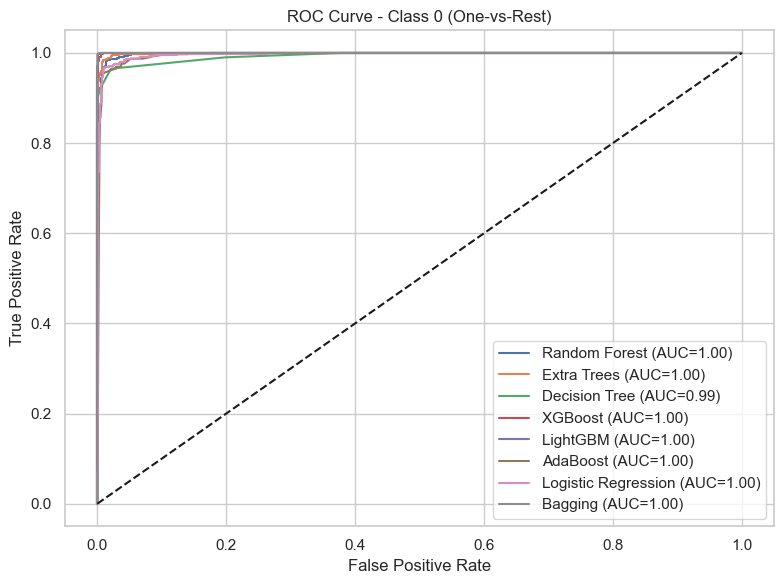

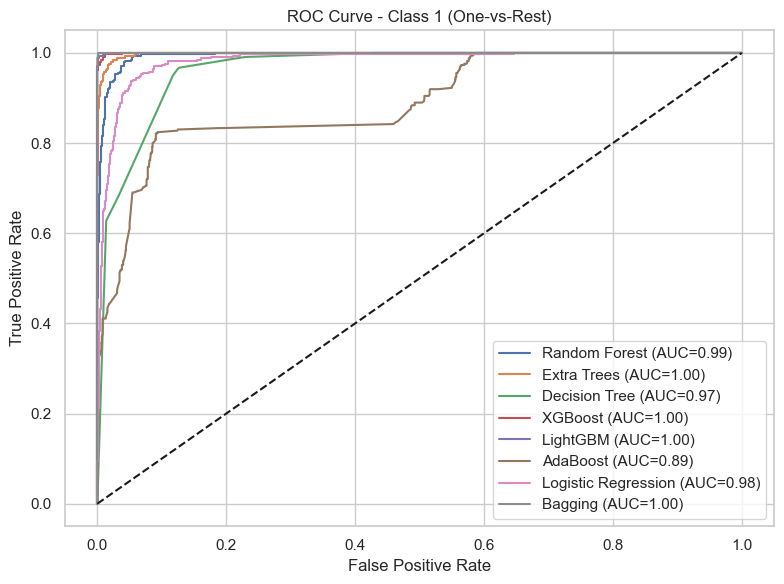

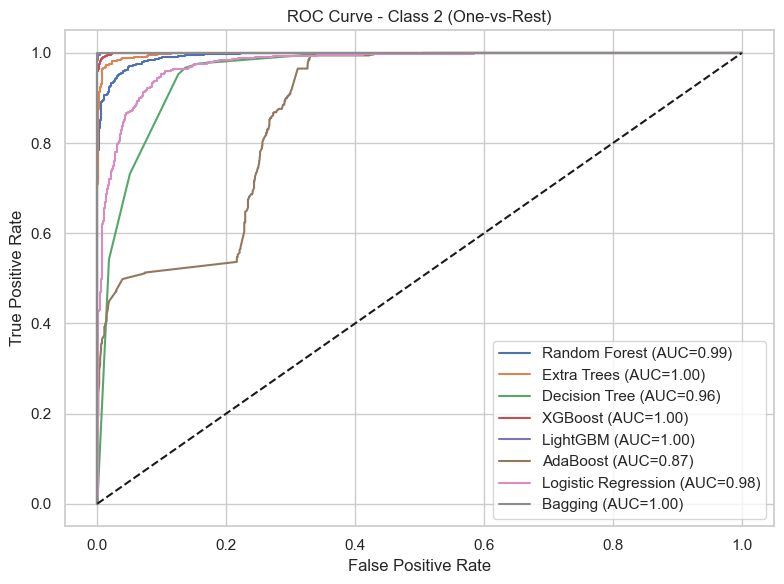

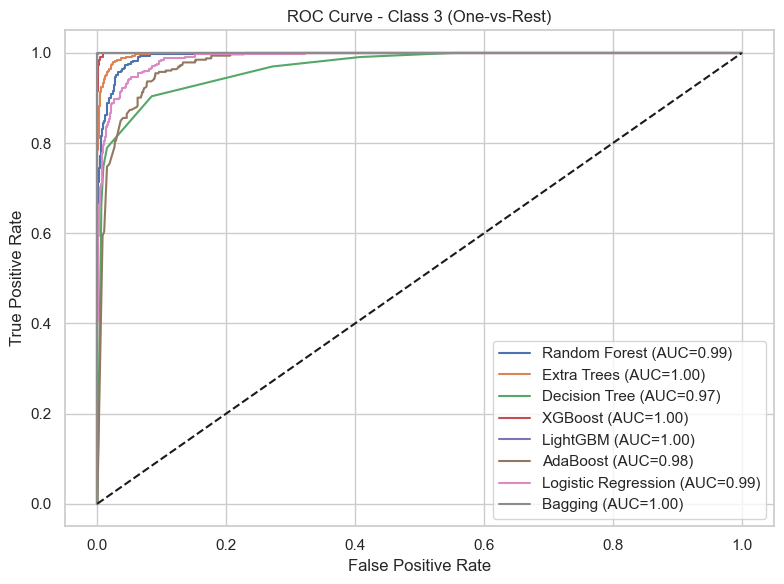

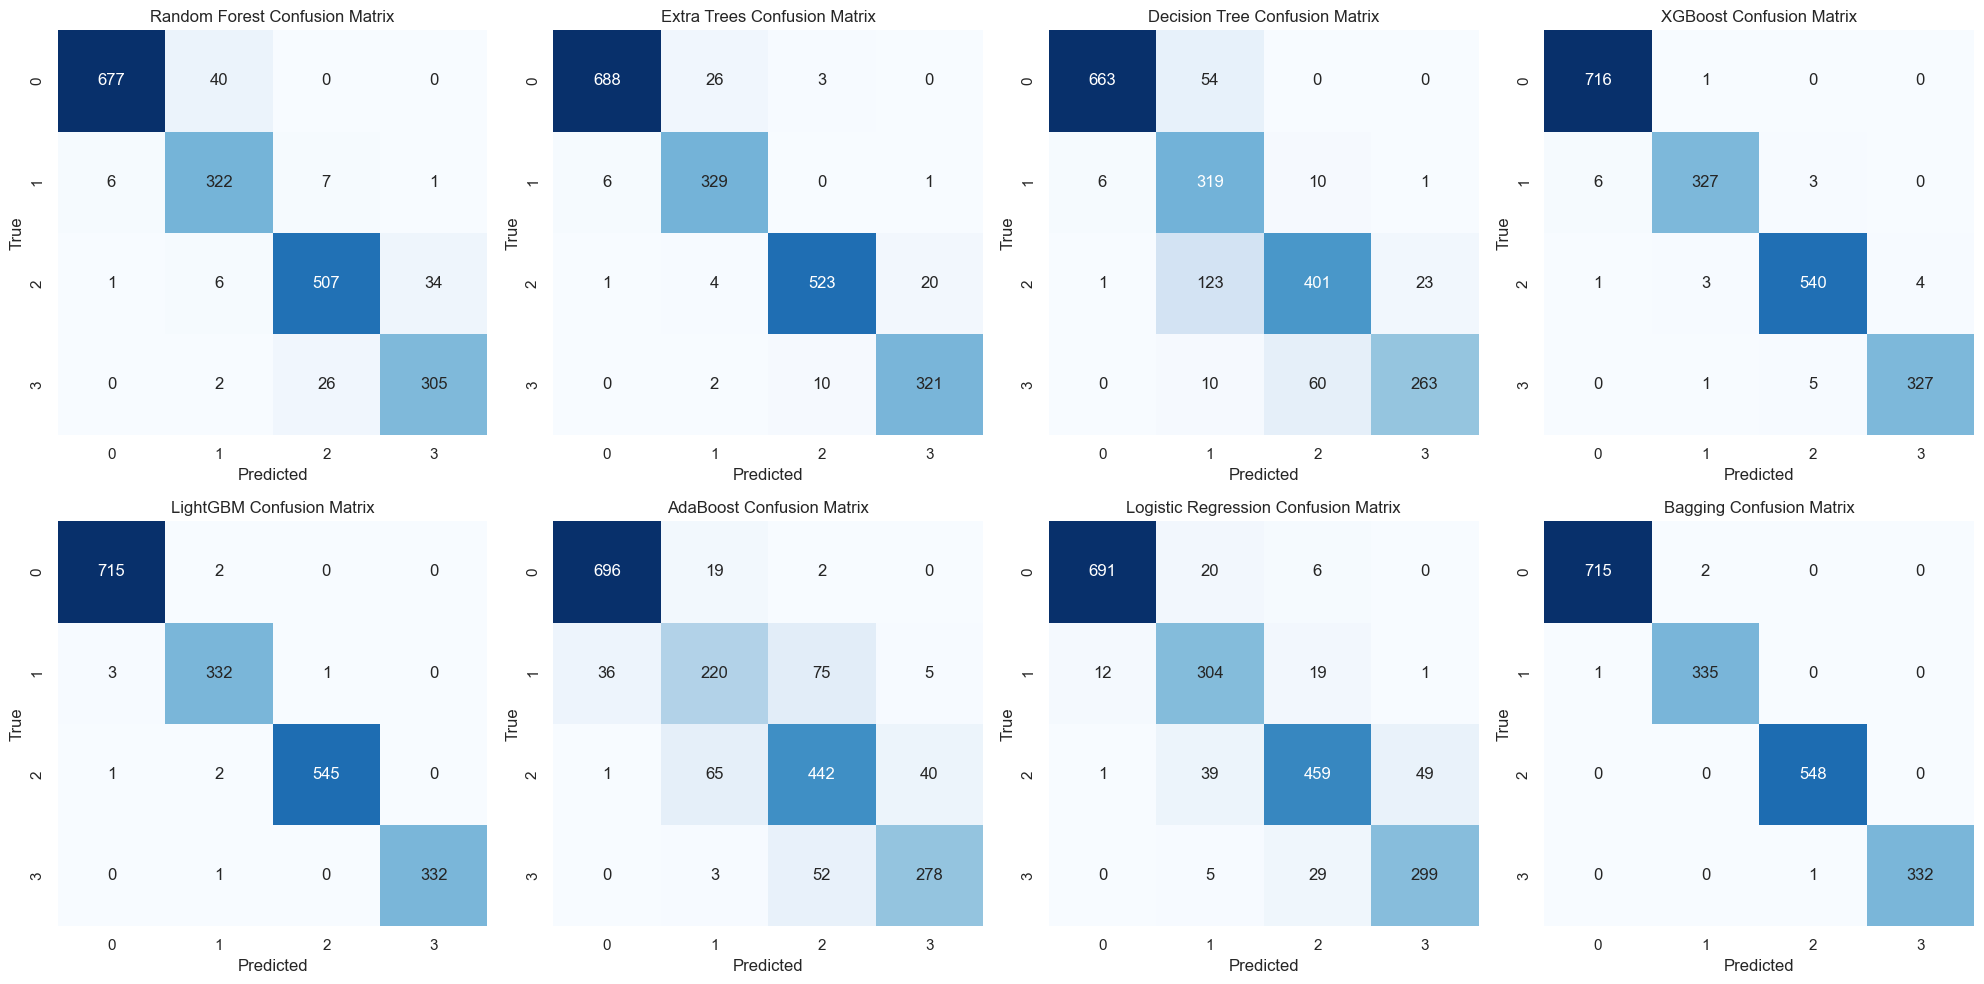

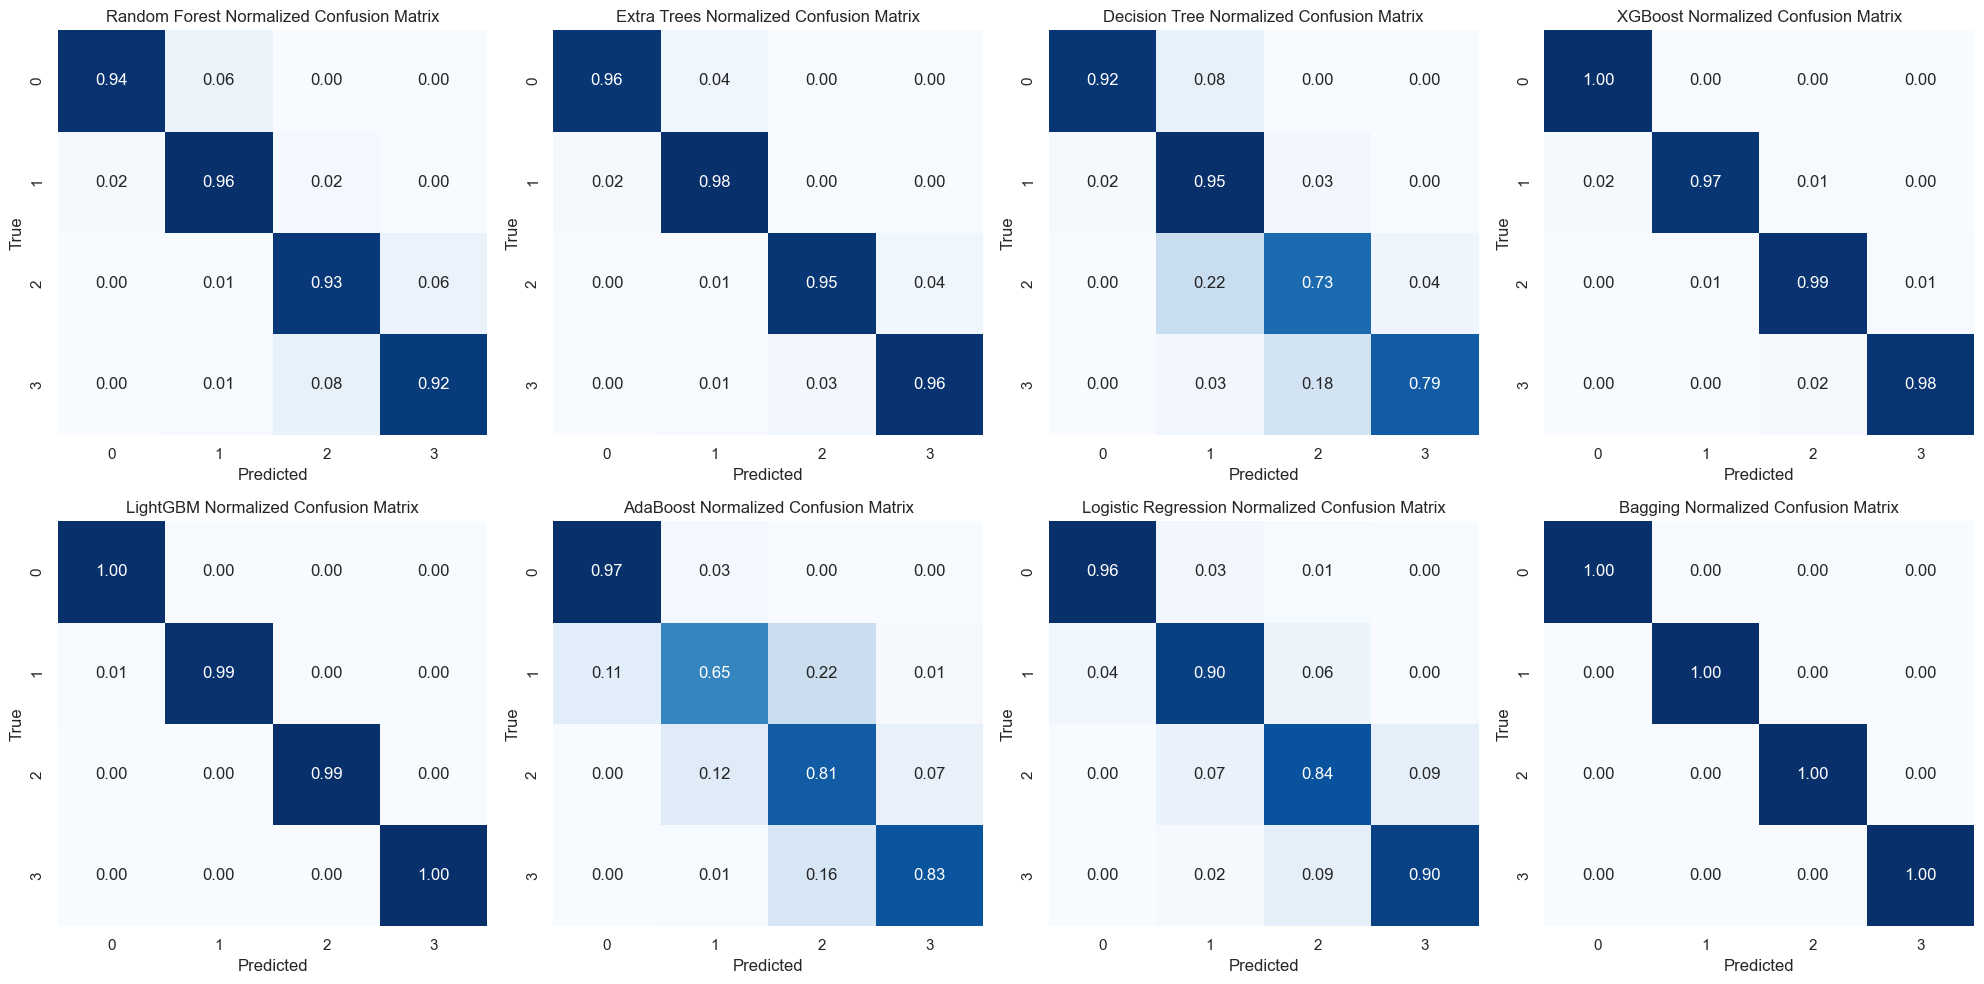

In [20]:
fit_evaluate_models_no_cv(X_train, y_train)

In [21]:
import os
import joblib
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def explain_all_models(
    X_train,
    y_train,
    model_dir='../results/all_models',
    max_display=15,
    background_size=200,
    shap_sample_size=1000,
    output_dir=None,
    random_state=42
):
    """
    Carica tutti i modelli .joblib in model_dir e produce spiegazioni globali basate sui valori SHAP.

    Parametri:
    - X_train: pd.DataFrame, dati di addestramento
    - y_train: pd.Series o np.array, target di addestramento (usato solo per info)
    - model_dir: str, cartella dove sono salvati i modelli .joblib
    - max_display: int, numero massimo di feature da mostrare nei grafici SHAP
    - background_size: int, numero di osservazioni usate come background per gli explainers che lo richiedono
    - shap_sample_size: int, numero massimo di righe su cui calcolare i valori SHAP (per performance)
    - output_dir: str o None, se fornito salva i plot in questa cartella
    - random_state: int, seme per campionamenti riproducibili

    Ritorna:
    - results: dict mapping model_name -> dict con keys:
        - "importances": pd.DataFrame con 'Feature' e 'MeanAbsSHAP' ordinate desc
        - "explainer": oggetto explainer (se disponibile)
        - "shap_values": shap values (solo per ispezioni ulteriori; può essere pesante)
    """

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    # Trova file .joblib
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.joblib')]
    if len(model_files) == 0:
        raise FileNotFoundError(f"Nessun file .joblib trovato in {model_dir}")

    results = {}

    for f in model_files:
        model_path = os.path.join(model_dir, f)
        model_name = f.replace('.joblib', '').replace('_', ' ')
        print(f"\n===== MODEL: {model_name} =====")
        try:
            model = joblib.load(model_path)
        except Exception as e:
            print(f"Errore caricamento modello {model_name}: {e}")
            continue

        # Sample per background e per calcolo SHAP (per efficienza)
        rng = np.random.RandomState(random_state)
        n = len(X_train)
        bg_n = min(background_size, n)
        sample_n = min(shap_sample_size, n)

        background = shap.sample(X_train, bg_n, random_state=random_state)
        X_for_shap = shap.sample(X_train, sample_n, random_state=random_state)

        explainer = None
        shap_values = None

        # Scegli explainer preferenziale (TreeExplainer per modelli ad albero, altrimenti shap.Explainer)
        try:
            cls_name = model.__class__.__name__.lower()
            is_tree_like = ('tree' in cls_name) or hasattr(model, "feature_importances_") \
                           or 'randomforest' in cls_name or 'xgb' in cls_name or 'lgb' in cls_name

            # Se il modello è classificatore con predict_proba, preferiamo passare predict_proba all'explainer
            is_classifier = hasattr(model, "predict_proba")
            model_fn = None
            if is_classifier:
                # for shap.Explainer it's ok passare la funzione predict_proba (restituisce array NxC)
                model_fn = model.predict_proba

            if is_tree_like:
                # TreeExplainer è più efficiente e accurato per modelli ad albero
                try:
                    explainer = shap.TreeExplainer(model, data=background)
                    # Nuova API: calling explainer(X) ritorna un Explanation object
                    shap_expl = explainer(X_for_shap)
                    shap_values = shap_expl.values
                except Exception as e:
                    # fallback a shap.Explainer
                    print(f"TreeExplainer non ha funzionato per {model_name}, provo shap.Explainer: {e}")
                    if model_fn is not None:
                        explainer = shap.Explainer(model_fn, background)
                    else:
                        explainer = shap.Explainer(model, background)
                    shap_expl = explainer(X_for_shap)
                    shap_values = shap_expl.values
            else:
                # General explainer (KernelExplainer è pesante; shap.Explainer sceglie la migliore strategia)
                if model_fn is not None:
                    explainer = shap.Explainer(model_fn, background)
                else:
                    explainer = shap.Explainer(model, background)
                shap_expl = explainer(X_for_shap)
                shap_values = shap_expl.values

        except Exception as e:
            print(f"SHAP non disponibile per {model_name}: {e}")
            continue

        # Normalizza/gestisci formati diversi di shap_values:
        # - può essere ndarray (n_samples, n_features)
        # - oppure ndarray (n_samples, n_features, ?) ma solitamente (n_samples, n_features)
        # - per multi-classe spesso è una lista di array oppure array con shape (n_classes, n_samples, n_features)
        try:
            # helper per calcolare mean(|shap|) per feature
            def mean_abs_shap_per_feature(shap_vals):
                """
                Accetta shap_vals che può essere:
                 - numpy array (n_samples, n_features)
                 - list of arrays (per classe) each (n_samples, n_features)
                 - array (n_classes, n_samples, n_features)
                Restituisce array (n_features,) con mean(abs(shap)) aggregata opportunamente.
                """
                if isinstance(shap_vals, list):
                    # lista di array: calcolo mean abs per classe, poi media tra classi
                    per_class_means = []
                    for arr in shap_vals:
                        arr = np.asarray(arr)
                        # se arr ha shape (n_samples, n_features)
                        if arr.ndim == 2:
                            per_class_means.append(np.mean(np.abs(arr), axis=0))
                        elif arr.ndim == 3:
                            # possibile (n_samples, n_features, something) -> tentativo semplificativo
                            per_class_means.append(np.mean(np.abs(arr.reshape(arr.shape[0], -1)), axis=0))
                        else:
                            raise ValueError("Formato shap array non riconosciuto (list case).")
                    return np.mean(np.vstack(per_class_means), axis=0)
                else:
                    arr = np.asarray(shap_vals)
                    if arr.ndim == 2:
                        # (n_samples, n_features)
                        return np.mean(np.abs(arr), axis=0)
                    elif arr.ndim == 3:
                        # (n_classes, n_samples, n_features) oppure (n_samples, n_features, something)
                        # caso più comune: (n_classes, n_samples, n_features)
                        if arr.shape[0] <= 50 and arr.shape[0] < arr.shape[1]:
                            # probabilmente (n_classes, n_samples, n_features)
                            # mean abs across samples then average across classes
                            mean_per_class = np.mean(np.abs(arr), axis=1)  # (n_classes, n_features)
                            return np.mean(mean_per_class, axis=0)
                        else:
                            # altrimenti proviamo a considerarlo (n_samples, n_features, extra) -> riduciamo l'extra
                            s = arr.reshape(arr.shape[0], arr.shape[1], -1)
                            # collapse last dim by mean
                            collapsed = np.mean(s, axis=-1)  # (n_samples, n_features)
                            return np.mean(np.abs(collapsed), axis=0)
                    else:
                        raise ValueError("Formato shap array non riconosciuto.")
            
            mean_abs = mean_abs_shap_per_feature(shap_values)
            importance_df = pd.DataFrame({
                'Feature': list(X_train.columns),
                'MeanAbsSHAP': mean_abs
            })
            importance_df.sort_values('MeanAbsSHAP', ascending=False, inplace=True)
            importance_df.reset_index(drop=True, inplace=True)
        except Exception as e:
            print(f"Errore nel calcolo delle importanze SHAP per {model_name}: {e}")
            continue

        # Mostro i top-k in tabella
        print("Top features by mean(|SHAP|):")
        print(importance_df.head(max_display).to_string(index=False))

        # Plot SHAP summary (usa shap_values dell'explainer)
        try:
            print("Genero SHAP summary plot (globale)...")
            # Per il plot globale scegliamo cosa passare:
            # - se shap_values è lista e ci sono 2 classi, plot della classe positiva (1)
            # - se lista >2 scegli la classe con mean_abs maggiore
            shap_values_to_plot = shap_values
            if isinstance(shap_values, list):
                if len(shap_values) == 2:
                    shap_values_to_plot = shap_values[1]
                else:
                    # prendi la classe con più importanza media
                    class_means = [np.mean(np.abs(v)) for v in shap_values]
                    idx = int(np.argmax(class_means))
                    shap_values_to_plot = shap_values[idx]
                    print(f"Multi-classe: plot della classe {idx} (mean abs SHAP maggiore).")
            else:
                arr = np.asarray(shap_values)
                # se arr ha shape (n_classes, n_samples, n_features)
                if arr.ndim == 3 and arr.shape[0] > 1:
                    # scegli la classe con mean abs maggiore
                    mean_per_class = np.mean(np.abs(arr), axis=(1,2))
                    idx = int(np.argmax(mean_per_class))
                    shap_values_to_plot = arr[idx]
                    print(f"Multi-classe (array): plot della classe {idx} (mean abs SHAP maggiore).")

            # summary_plot accetta sia arrays che Explanation objects; usiamo i valori e X_for_shap per corrispondenza
            plt.figure(figsize=(8, 6))
            shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)
            if output_dir:
                fname = os.path.join(output_dir, f"{model_name}_shap_summary.png")
                plt.savefig(fname, bbox_inches='tight')
                print(f"Saved summary plot to {fname}")
            plt.close()
        except Exception as e:
            print(f"Impossibile generare summary plot per {model_name}: {e}")

        # Bar plot delle importanze derivate da SHAP (mean abs)
        try:
            top_k = importance_df.head(max_display).iloc[::-1]  # invertito per barh
            fig, ax = plt.subplots(figsize=(8, max(4, 0.3 * len(top_k))))
            ax.barh(top_k['Feature'], top_k['MeanAbsSHAP'])
            ax.set_xlabel("Mean |SHAP value|")
            ax.set_title(f"Feature importance SHAP - {model_name}")
            plt.tight_layout()
            if output_dir:
                fname = os.path.join(output_dir, f"{model_name}_shap_bar.png")
                plt.savefig(fname, bbox_inches='tight')
                print(f"Saved bar plot to {fname}")
            plt.show()
            plt.close()
        except Exception as e:
            print(f"Impossibile generare bar plot SHAP per {model_name}: {e}")

        # Salvo risultati
        results[model_name] = {
            "importances": importance_df,
            "explainer": explainer,
            "shap_values": shap_values  # attenzione: può essere pesante
        }

    return results



===== MODEL: Decision Tree =====
Top features by mean(|SHAP|):
        Feature  MeanAbsSHAP
       PTEDUCAT 2.296153e-09
          CDRSB 1.805859e-09
      LDELTOTAL 1.466431e-09
     mPACCdigit 1.106053e-09
     EcogSPPlan 4.846789e-10
           MOCA 4.108180e-10
     PTAU/ABETA 3.758655e-10
           MMSE 3.029360e-10
   EcogPtDivatt 1.192093e-12
          APOE4 0.000000e+00
        MARRIED 0.000000e+00
       PTGENDER 0.000000e+00
            AGE 0.000000e+00
RAVLT_immediate 0.000000e+00
 RAVLT_learning 0.000000e+00
Genero SHAP summary plot (globale)...
Multi-classe (array): plot della classe 341 (mean abs SHAP maggiore).
Impossibile generare summary plot per Decision Tree: The shape of the shap_values matrix does not match the shape of the provided data matrix.


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\4218233106.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)


<Figure size 800x600 with 0 Axes>

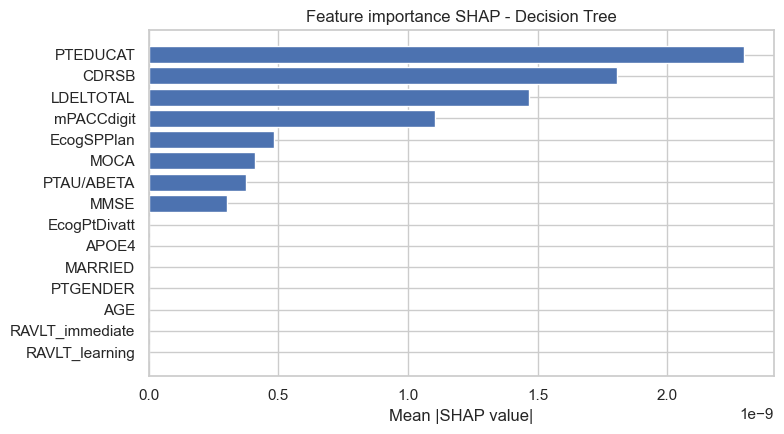


===== MODEL: Extra Trees =====


 96%|=================== | 3820/4000 [00:21<00:00]       

Top features by mean(|SHAP|):
     Feature  MeanAbsSHAP
       CDRSB 8.875548e-10
   LDELTOTAL 4.393938e-10
  mPACCdigit 2.910585e-10
   EcogSPMem 2.084633e-10
        MMSE 1.899590e-10
         FAQ 1.736432e-10
      ADAS13 1.330927e-10
EcogSPDivatt 9.114995e-11
  EcogSPPlan 8.840764e-11
    PTEDUCAT 8.689452e-11
   EcogPtMem 8.416674e-11
 EcogSPOrgan 8.346688e-11
  EcogSPLang 7.646990e-11
        MOCA 7.482943e-11
Fusiform/ICV 7.414453e-11
Genero SHAP summary plot (globale)...
Multi-classe (array): plot della classe 524 (mean abs SHAP maggiore).
Impossibile generare summary plot per Extra Trees: The shape of the shap_values matrix does not match the shape of the provided data matrix.


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\4218233106.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)


<Figure size 800x600 with 0 Axes>

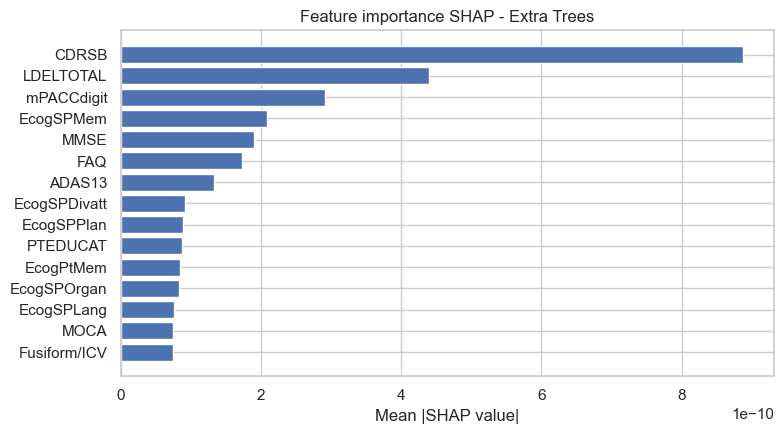


===== MODEL: LightGBM =====


 95%|=================== | 3816/4000 [00:22<00:01]       

Top features by mean(|SHAP|):
        Feature  MeanAbsSHAP
      LDELTOTAL     0.133122
     mPACCdigit     0.114103
          CDRSB     0.068178
            FAQ     0.045363
           MMSE     0.042412
       PTEDUCAT     0.036545
      EcogSPMem     0.021724
       TRABSCOR     0.016245
 Entorhinal/ICV     0.015196
Hippocampus/ICV     0.014332
            FDG     0.013818
    EcogPtOrgan     0.013226
         ADAS13     0.012789
   Fusiform/ICV     0.012234
 WholeBrain/ICV     0.012233
Genero SHAP summary plot (globale)...
Multi-classe (array): plot della classe 612 (mean abs SHAP maggiore).
Impossibile generare summary plot per LightGBM: The shape of the shap_values matrix does not match the shape of the provided data matrix.


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\4218233106.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)


<Figure size 800x600 with 0 Axes>

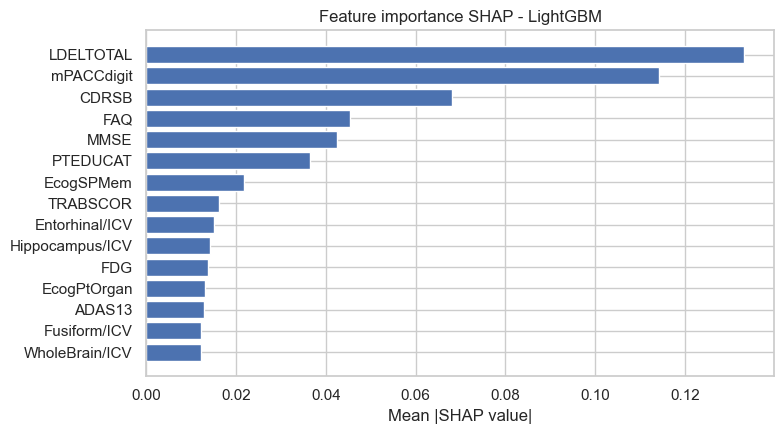


===== MODEL: Random Forest =====
TreeExplainer non ha funzionato per Random Forest, provo shap.Explainer: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.189741, while the model output was 0.206555. If this difference is acceptable you can set check_additivity=False to disable this check.


PermutationExplainer explainer: 1001it [01:10, 12.32it/s]                          

Top features by mean(|SHAP|):
        Feature  MeanAbsSHAP
          CDRSB 3.150019e-17
     mPACCdigit 2.894032e-17
      LDELTOTAL 2.828987e-17
      EcogSPMem 2.530160e-17
           MMSE 2.041010e-17
 WholeBrain/ICV 2.017855e-17
           MOCA 1.993921e-17
         ADAS13 1.928549e-17
     EcogSPLang 1.719789e-17
RAVLT_immediate 1.648563e-17
   Fusiform/ICV 1.576375e-17
            FAQ 1.516730e-17
 Entorhinal/ICV 1.475201e-17
    MidTemp/ICV 1.472626e-17
       PTEDUCAT 1.468875e-17
Genero SHAP summary plot (globale)...
Multi-classe (array): plot della classe 707 (mean abs SHAP maggiore).
Impossibile generare summary plot per Random Forest: The shape of the shap_values matrix does not match the shape of the provided data matrix.



C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\4218233106.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)


<Figure size 800x600 with 0 Axes>

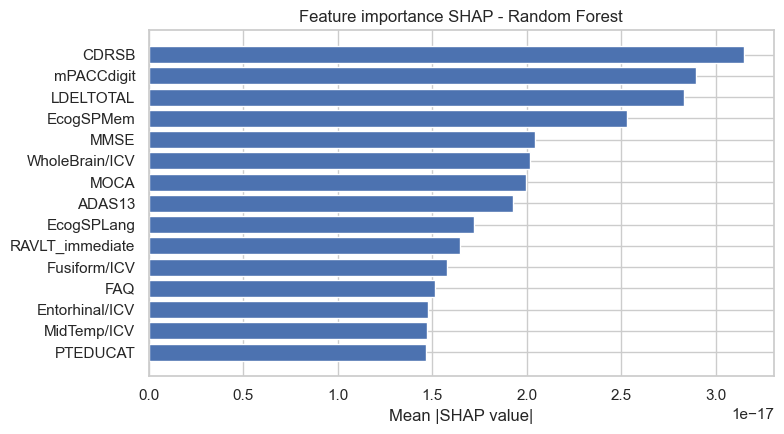


===== MODEL: XGBoost =====


 97%|=================== | 3887/4000 [00:22<00:00]       

Top features by mean(|SHAP|):
       Feature  MeanAbsSHAP
     LDELTOTAL     0.108288
         CDRSB     0.084758
    mPACCdigit     0.072332
           FAQ     0.032687
          MMSE     0.028367
     EcogSPMem     0.025951
WholeBrain/ICV     0.019476
      PTEDUCAT     0.015796
      TRABSCOR     0.014694
        ADAS13     0.013609
     TAU/ABETA     0.012267
   EcogPtOrgan     0.011696
          MOCA     0.011546
Entorhinal/ICV     0.011231
  Fusiform/ICV     0.010608
Genero SHAP summary plot (globale)...
Multi-classe (array): plot della classe 590 (mean abs SHAP maggiore).
Impossibile generare summary plot per XGBoost: The shape of the shap_values matrix does not match the shape of the provided data matrix.


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\4218233106.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_for_shap, show=True, max_display=max_display)


<Figure size 800x600 with 0 Axes>

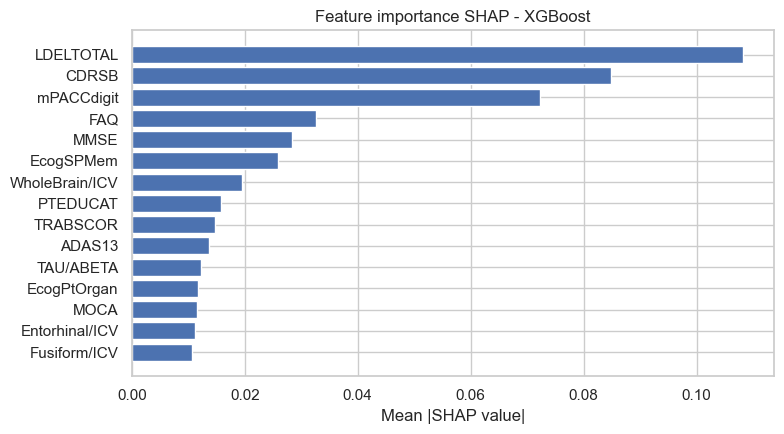

{'Decision Tree': {'importances':                   Feature   MeanAbsSHAP
  0                PTEDUCAT  2.296153e-09
  1                   CDRSB  1.805859e-09
  2               LDELTOTAL  1.466431e-09
  3              mPACCdigit  1.106053e-09
  4              EcogSPPlan  4.846789e-10
  5                    MOCA  4.108180e-10
  6              PTAU/ABETA  3.758655e-10
  7                    MMSE  3.029360e-10
  8            EcogPtDivatt  1.192093e-12
  9                   APOE4  0.000000e+00
  10                MARRIED  0.000000e+00
  11               PTGENDER  0.000000e+00
  12                    AGE  0.000000e+00
  13        RAVLT_immediate  0.000000e+00
  14         RAVLT_learning  0.000000e+00
  15  RAVLT_perc_forgetting  0.000000e+00
  16              EcogPtMem  0.000000e+00
  17             EcogPtLang  0.000000e+00
  18                 ADAS13  0.000000e+00
  19               TRABSCOR  0.000000e+00
  20                    FAQ  0.000000e+00
  21            EcogPtOrgan  0.000000e+00
  

In [ ]:
model_dir = '../results/all_models'
# explain_all_models(X_train, y_train, model_dir=model_dir)

[train] XGBoost ...
  -> XGBoost accuracy: 0.9314 ± 0.0105
[train] LightGBM ...
  -> LightGBM accuracy: 0.9285 ± 0.0112
[train] RandomForest ...
  -> RandomForest accuracy: 0.8968 ± 0.0123
[ablation] model: XGBoost
  drop 00: 0.9249 ± 0.0117
  drop 01: 0.8258 ± 0.0152
  drop 02: 0.7537 ± 0.0144
  drop 03: 0.7275 ± 0.0126
  drop 04: 0.7273 ± 0.0130
  drop 05: 0.7270 ± 0.0156
  drop 06: 0.7223 ± 0.0136
  drop 07: 0.7186 ± 0.0158
  drop 08: 0.7208 ± 0.0181
  drop 09: 0.6968 ± 0.0160
  drop 10: 0.6942 ± 0.0151
  drop 11: 0.6813 ± 0.0174
  drop 12: 0.6734 ± 0.0197
  drop 13: 0.6758 ± 0.0192
  drop 14: 0.6725 ± 0.0205
  drop 15: 0.6744 ± 0.0175
  drop 16: 0.6691 ± 0.0198
  drop 17: 0.6649 ± 0.0163
  drop 18: 0.6691 ± 0.0168
  drop 19: 0.6670 ± 0.0160
  drop 20: 0.6613 ± 0.0134
  drop 21: 0.6624 ± 0.0185
  drop 22: 0.6532 ± 0.0165
  drop 23: 0.6451 ± 0.0142
  drop 24: 0.6384 ± 0.0139
  drop 25: 0.6334 ± 0.0140
  drop 26: 0.6267 ± 0.0081
  drop 27: 0.6160 ± 0.0172
  drop 28: 0.5520 ± 0.0182
  

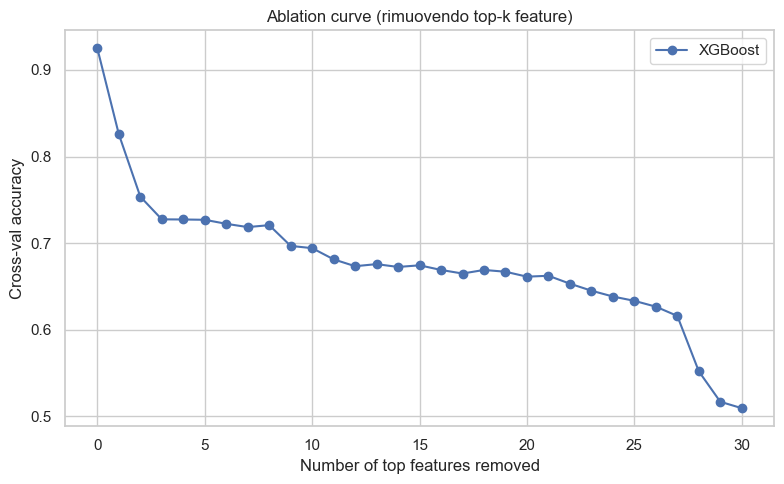

[noise] level 0.000 -> 0.9249 ± 0.0117


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\492347954.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.73728193 19.14141867  0.05712782 ...  9.89592707 12.7483957
 15.07311413]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]


[noise] level 0.050 -> 0.9243 ± 0.0106


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\492347954.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.45292433 18.80032038 -1.67707697 ...  9.52141089 13.29992731
 14.45587149]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]


[noise] level 0.100 -> 0.9006 ± 0.0136


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\492347954.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.56170939 17.21467908 -0.10472157 ...  9.54055239 13.19165744
 14.42790204]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]


[noise] level 0.250 -> 0.8397 ± 0.0175


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\492347954.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.44455952 16.22369256 -2.82752728 ... 10.15202372 12.88921429
 13.98612934]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]


[noise] level 0.500 -> 0.7830 ± 0.0162


C:\Users\Utente\AppData\Local\Temp\ipykernel_20004\492347954.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-6.46149956 20.56390875 -5.22704287 ... 13.05813694 11.64645798
 16.0950713 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]


[noise] level 1.000 -> 0.7549 ± 0.0118
[missing] rate 0.00 -> 0.9249 ± 0.0117
[missing] rate 0.05 -> 0.9019 ± 0.0122
[missing] rate 0.10 -> 0.9007 ± 0.0103
[missing] rate 0.20 -> 0.8812 ± 0.0125
[missing] rate 0.40 -> 0.8335 ± 0.0170


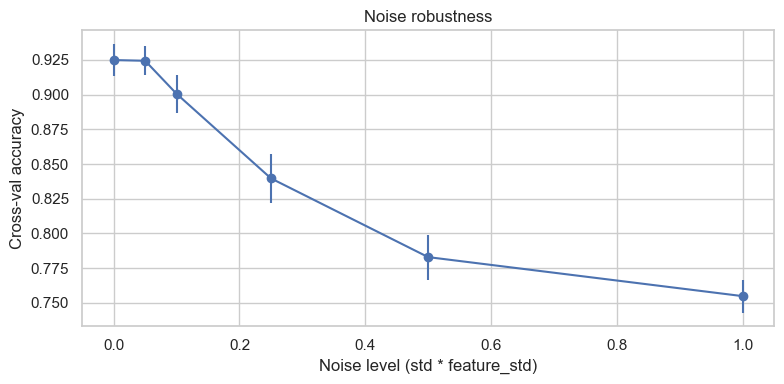

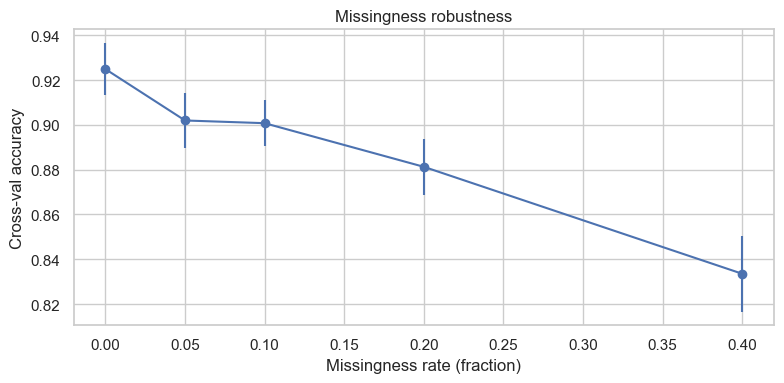


=== ONLY top-3 features ===
[train] XGBoost ...
  -> XGBoost accuracy: 0.8752 ± 0.0132
[train] LightGBM ...
  -> LightGBM accuracy: 0.8713 ± 0.0114
[train] RandomForest ...
  -> RandomForest accuracy: 0.8501 ± 0.0112

=== WITHOUT top-3 features ===
[train] XGBoost ...
  -> XGBoost accuracy: 0.7382 ± 0.0173
[train] LightGBM ...
  -> LightGBM accuracy: 0.7361 ± 0.0129
[train] RandomForest ...
  -> RandomForest accuracy: 0.7277 ± 0.0161
Done. Summary saved to comparison_baseline_only3_without3.csv


In [29]:
# model_ablation_robustness.py
# Dipendenze: scikit-learn, xgboost, lightgbm, shap, matplotlib, pandas, joblib, numpy, seaborn
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ---------------------------
# Utility: modelli (puoi personalizzare iperparametri)
# ---------------------------
# ---------------------------
# Caricamento dati (adatta i path)
# ---------------------------
def load_data(train_path="../data/train.csv", test_path="../data/test.csv", target_col="DX"):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col]) if target_col in test.columns else test.copy()
    y_test = test[target_col] if target_col in test.columns else None
    return X_train, y_train, X_test, y_test

# ---------------------------
# Ablation curve (rimuovi top-k feature e misura performance)
# ordered_features: lista ordinata di feature (più importanti prima)
# models: dict of models (default XGBoost)
# returns: dict mapping model -> list of (k, mean_score)
# ---------------------------
def ablation_curve(X, y, ordered_features, models=None, ks=None, cv=None, scoring='accuracy'):
    if models is None:
        models = {"XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')}
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    if ks is None:
        ks = list(range(0, min(30, len(ordered_features))+1))  # default fino a 30
    results = {}
    for name, clf in models.items():
        print(f"[ablation] model: {name}")
        model_results = []
        for k in ks:
            to_drop = ordered_features[:k]
            Xk = X.drop(columns=to_drop, errors='ignore')
            # pipeline with imputer+scaler
            pipe = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()), ("clf", clf)])
            scores = cross_val_score(pipe, Xk, y, cv=cv, scoring=scoring, n_jobs=-1)
            model_results.append((k, scores.mean(), scores.std()))
            print(f"  drop {k:02d}: {scores.mean():.4f} ± {scores.std():.4f}")
        results[name] = model_results
    return results

def plot_ablation(results, ks=None, title="Ablation curve"):
    plt.figure(figsize=(8,5))
    for model_name, vals in results.items():
        ks = [v[0] for v in vals]
        means = [v[1] for v in vals]
        plt.plot(ks, means, marker='o', label=model_name)
    plt.xlabel("Number of top features removed")
    plt.ylabel("Cross-val accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# Robustness to noise / missingness
# - gaussian_noise_levels: list of std-multipliers to add (multiplicative w.r.t feature std)
# - missingness_rates: list of fractions [0..1] to randomly set to NaN on selected features
# - features_to_test: list of feature names
# - model: classifier pipeline
# ---------------------------
def noise_and_missingness_test(X, y, features_to_test, model=None,
                               gaussian_noise_levels=[0.0, 0.05, 0.1, 0.25, 0.5, 1.0],
                               missingness_rates=[0.0, 0.05, 0.1, 0.2, 0.4],
                               cv=None, scoring='accuracy'):
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    if model is None:
        model = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()),
                          ("clf", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))])
    rng = np.random.RandomState(42)
    results_noise = {}
    results_missing = {}
    # Precompute std of features
    feature_stds = X[features_to_test].std(skipna=True)

    # ---- Noise
    for level in gaussian_noise_levels:
        X_noisy = X.copy()
        for f in features_to_test:
            std_f = feature_stds[f] if not np.isnan(feature_stds[f]) else 0.0
            noise = rng.normal(loc=0.0, scale=level * std_f, size=X.shape[0])
            # add noise only where not null
            mask = X_noisy[f].notnull()
            X_noisy.loc[mask, f] = X_noisy.loc[mask, f] + noise[mask]
        scores = cross_val_score(model, X_noisy, y, cv=cv, scoring=scoring, n_jobs=-1)
        results_noise[level] = (scores.mean(), scores.std())
        print(f"[noise] level {level:.3f} -> {scores.mean():.4f} ± {scores.std():.4f}")

    # ---- Missingness
    for rate in missingness_rates:
        X_missing = X.copy()
        X_missing = X_missing.reset_index(drop=True)
        n_samples = X_missing.shape[0]
        for f in features_to_test:
            n_miss = int(rate * n_samples)
            miss_idx = rng.choice(n_samples, size=n_miss, replace=False)
            X_missing.loc[miss_idx, f] = np.nan
        # impute + evaluate in cross-val inside pipeline
        scores = cross_val_score(model, X_missing, y, cv=cv, scoring=scoring, n_jobs=-1)
        results_missing[rate] = (scores.mean(), scores.std())
        print(f"[missing] rate {rate:.2f} -> {scores.mean():.4f} ± {scores.std():.4f}")

    return results_noise, results_missing

def plot_noise_missing(results_noise, results_missing, title_noise="Noise robustness", title_missing="Missingness robustness"):
    # noise
    levels = sorted(results_noise.keys())
    means = [results_noise[l][0] for l in levels]
    stds = [results_noise[l][1] for l in levels]
    plt.figure(figsize=(8,4))
    plt.errorbar(levels, means, yerr=stds, marker='o')
    plt.xlabel("Noise level (std * feature_std)")
    plt.ylabel("Cross-val accuracy")
    plt.title(title_noise)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # missing
    rates = sorted(results_missing.keys())
    means = [results_missing[r][0] for r in rates]
    stds = [results_missing[r][1] for r in rates]
    plt.figure(figsize=(8,4))
    plt.errorbar(rates, means, yerr=stds, marker='o')
    plt.xlabel("Missingness rate (fraction)")
    plt.ylabel("Cross-val accuracy")
    plt.title(title_missing)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Helper: estrarre top features da SHAP usando un modello ad albero (opzionale / lento)
# Nota: nel tuo notebook hai già una funzione explain_all_models che produce importances SHAP.
# (vedi il tuo notebook / PDF per l'implementazione). :contentReference[oaicite:2]{index=2}
# ---------------------------
def get_shap_ordered_features(model, X, n_sample=1000, random_state=42):
    import shap
    rng = np.random.RandomState(random_state)
    # sample background e X_for_shap
    bg = shap.sample(X, min(200, len(X)), random_state=random_state)
    Xs = shap.sample(X, min(n_sample, len(X)), random_state=random_state)
    try:
        explainer = shap.TreeExplainer(model, data=bg)
        shap_vals = explainer(Xs).values
    except Exception:
        explainer = shap.Explainer(model.predict_proba, bg)
        shap_vals = explainer(Xs).values
    # mean abs per feature (support multi-class shapes)
    arr = np.asarray(shap_vals)
    if arr.ndim == 3:
        # (n_samples, n_features, ?) or (n_classes, n_samples, n_features)
        # try common shapes:
        if arr.shape[0] <= 50 and arr.shape[0] < arr.shape[1]:
            # probably (n_classes, n_samples, n_features)
            mean_per_class = np.mean(np.abs(arr), axis=1)
            mean_abs = np.mean(mean_per_class, axis=0)
        else:
            collapsed = arr.reshape(arr.shape[0], arr.shape[1], -1)
            mean_abs = np.mean(np.abs(collapsed), axis=(0,2))
    else:
        mean_abs = np.mean(np.abs(arr), axis=0)
    feat_df = pd.DataFrame({"feature": X.columns, "mean_abs_shap": mean_abs})
    feat_df = feat_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
    return list(feat_df['feature']), feat_df

# ---------------------------
# Esempio di pipeline "main" che esegue i test richiesti
# ---------------------------
if __name__ == "__main__":
    # 1) load
    X_train, y_train, X_test, y_test = load_data(train_path="../data/train.csv", test_path="../data/test.csv")

    # 2) fit & evaluate baseline (full features)
    baseline_results = fit_evaluate_store_models(X_train, y_train, output_dir="./results_models_full")

    # 3) se hai già SHAP ordering (o puoi calcolarlo qui su LightGBM/XGBoost), estrai top features
    # Nota: nel tuo notebook il top-3 erano CDRSB, LDELTOTAL, mPACCdigit (visto nei risultati SHAP). :contentReference[oaicite:3]{index=3}
    # Puoi costruire ordered_features manualmente, e.g.:
    ordered_features = ["LDELTOTAL", "CDRSB", "mPACCdigit"] + [c for c in X_train.columns if c not in ["LDELTOTAL","CDRSB","mPACCdigit"]]

    # 4) ablation curve
    models_for_ablation = {"XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')}
    ablation_results = ablation_curve(X_train, y_train, ordered_features, models=models_for_ablation, ks=list(range(0, 31)))
    plot_ablation(ablation_results, title="Ablation curve (rimuovendo top-k feature)")

    # 5) test rumore/missingness sulle top-3
    features_to_test = ["CDRSB", "LDELTOTAL", "mPACCdigit"]
    model_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()),
                           ("clf", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))])
    noise_res, miss_res = noise_and_missingness_test(X_train, y_train, features_to_test, model=model_pipe)
    plot_noise_missing(noise_res, miss_res)

    # 6) test clinico pratico: train using only top-3 vs train without top-3
    X_only3 = X_train[["CDRSB","LDELTOTAL","mPACCdigit"]].copy()
    X_without3 = X_train.drop(columns=["CDRSB","LDELTOTAL","mPACCdigit"], errors='ignore')

    print("\n=== ONLY top-3 features ===")
    only3_res = fit_evaluate_store_models(X_only3, y_train, output_dir="./results_models_only3")
    print("\n=== WITHOUT top-3 features ===")
    without3_res = fit_evaluate_store_models(X_without3, y_train, output_dir="./results_models_without3")

    # salva risultati in CSV sintetico
    summary = []
    for d, label in [(baseline_results, "baseline"), (only3_res, "only3"), (without3_res, "without3")]:
        for mname, mres in d.items():
            summary.append({"setting": label, "model": mname, "mean_acc": mres["mean"], "std": mres["std"]})
    pd.DataFrame(summary).to_csv("comparison_baseline_only3_without3.csv", index=False)
    print("Done. Summary saved to comparison_baseline_only3_without3.csv")


In [ ]:
# esempio_notebook.py o in un Jupyter Notebook

import pandas as pd
from model_ablation_robustness import (
    load_data,
    fit_evaluate_store_models,
    ablation_curve,
    plot_ablation,
    noise_and_missingness_test,
    plot_noise_missing
)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1) Carica i dati
X_train, y_train, X_test, y_test = load_data(
    train_path="./data/NEWADNIMERGE_train.csv",
    test_path="./data/NEWADNIMERGE_test.csv",
    target_col="DX"
)

# 2) Allena e valuta i modelli baseline (tutte le feature)
baseline_results = fit_evaluate_store_models(X_train, y_train, output_dir="./results_baseline")

# 3) Definisci le feature ordinate (es. dalle SHAP importance che già conosci)
ordered_features = ["CDRSB", "LDELTOTAL", "mPACCdigit"] + [
    c for c in X_train.columns if c not in ["CDRSB", "LDELTOTAL", "mPACCdigit"]
]

# 4) Ablation curve (XGBoost) — rimozione progressiva delle feature più importanti
ablation_results = ablation_curve(
    X_train,
    y_train,
    ordered_features,
    models={"XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")},
    ks=list(range(0, 10))  # prova rimuovendo fino a 10 feature
)
plot_ablation(ablation_results, title="Ablation curve (rimozione top-k feature)")

# 5) Robustezza a rumore e missingness sulle tre feature chiave
features_to_test = ["CDRSB", "LDELTOTAL", "mPACCdigit"]
model_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss"))
])

noise_res, miss_res = noise_and_missingness_test(
    X_train, y_train, features_to_test, model=model_pipe
)
plot_noise_missing(noise_res, miss_res)

# 6) Confronto tra:
#    - modello baseline (tutte le feature)
#    - modello solo top-3
#    - modello senza top-3
X_only3 = X_train[["CDRSB", "LDELTOTAL", "mPACCdigit"]]
X_without3 = X_train.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"])

print("\n=== ONLY top-3 features ===")
only3_results = fit_evaluate_store_models(X_only3, y_train, output_dir="./results_only3")

print("\n=== WITHOUT top-3 features ===")
without3_results = fit_evaluate_store_models(X_without3, y_train, output_dir="./results_without3")

# 7) Salva un confronto sintetico
summary = []
for d, label in [(baseline_results, "baseline"),
                 (only3_results, "only3"),
                 (without3_results, "without3")]:
    for mname, mres in d.items():
        summary.append({"setting": label, "model": mname,
                        "mean_acc": mres["mean"], "std": mres["std"]})
pd.DataFrame(summary).to_csv("comparison_baseline_only3_without3.csv", index=False)
